<a href="https://colab.research.google.com/github/Ayush310803/ViT/blob/main/Segformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install transformers datasets torch torchvision numpy matplotlib opencv-python albumentations

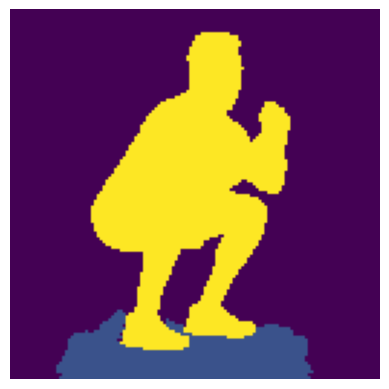

In [4]:
from transformers import SegformerFeatureExtractor, SegformerForSemanticSegmentation
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

model_name = "nvidia/segformer-b2-finetuned-ade-512-512"
feature_extractor = SegformerFeatureExtractor.from_pretrained(model_name)
model = SegformerForSemanticSegmentation.from_pretrained(model_name)

image = Image.open("/content/Bodyweight-Squat.jpg").convert("RGB")

inputs = feature_extractor(images=image, return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits

seg_mask = torch.argmax(logits, dim=1).squeeze().cpu().numpy()
plt.imshow(seg_mask)
plt.axis("off")
plt.show()


In [5]:
!pip install kaggle

In [6]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mv: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [7]:
!kaggle datasets download -d xiaohui9603/modanet-dataset
!unzip modanet-dataset.zip -d modanet_images

403 - Forbidden - Permission 'datasets.get' was denied
unzip:  cannot find or open modanet-dataset.zip, modanet-dataset.zip.zip or modanet-dataset.zip.ZIP.


In [8]:
!git clone https://github.com/eBay/modanet.git

Cloning into 'modanet'...
remote: Enumerating objects: 70, done.
remote: Total 70 (delta 0), reused 0 (delta 0), pack-reused 70 (from 1)
Receiving objects: 100% (70/70), 28.44 MiB | 15.92 MiB/s, done.
Resolving deltas: 100% (19/19), done.


In [9]:
!cd modanet

In [10]:
!md5 modanet2018_instances_train.json

/bin/bash: line 1: md5: command not found


In [11]:
import json

with open("modanet/annotations/modanet2018_instances_train.json", "r") as f:
    modanet_annotations = json.load(f)

print(modanet_annotations["annotations"][0])


{'segmentation': [[161, 248, 170, 248, 173, 249, 189, 251, 199, 252, 199, 250, 212, 250, 212, 252, 224, 253, 239, 251, 248, 250, 257, 247, 257, 253, 249, 255, 248, 260, 248, 265, 228, 264, 215, 264, 200, 264, 196, 261, 189, 260, 182, 259, 171, 259, 164, 255, 160, 254, 161, 254]], 'area': 1746, 'iscrowd': 0, 'image_id': 736791, 'bbox': [160, 247, 97, 18], 'category_id': 2, 'id': 0}


In [12]:
import cv2
import matplotlib.pyplot as plt

img_path = "modanet_images/000001.jpg"
if not os.path.exists(img_path):
    print(f"Error: Image file not found at {img_path}")
else:
    image = cv2.imread(img_path)

    if image is None:
        print(f"Error: Could not load image from {img_path}")
    else:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.imshow(image)
        plt.axis("off")
        plt.show()

NameError: name 'os' is not defined

In [ ]:
import os
import torch
import numpy as np
import cv2
from torchvision import transforms
from transformers import SegformerFeatureExtractor

feature_extractor = SegformerFeatureExtractor.from_pretrained("nvidia/segformer-b2-finetuned-ade-512-512")

IMAGE_DIR = "modnet_data/images"
MASK_DIR = "modnet_data/masks"

def preprocess_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (512, 512))
    return image

def preprocess_mask(mask_path):
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (512, 512))
    mask = mask / 255
    return mask.astype(np.uint8)

def load_dataset():
    images, masks = [], []
    for img_name in os.listdir(IMAGE_DIR):
        img_path = os.path.join(IMAGE_DIR, img_name)
        mask_path = os.path.join(MASK_DIR, img_name.replace(".jpg", ".png"))

        image = preprocess_image(img_path)
        mask = preprocess_mask(mask_path)

        images.append(image)
        masks.append(mask)

    return images, masks

images, masks = load_dataset()


In [ ]:
from torch.utils.data import Dataset, DataLoader

class MODNetDataset(Dataset):
    def __init__(self, images, masks, feature_extractor):
        self.images = images
        self.masks = masks
        self.feature_extractor = feature_extractor

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = self.masks[idx]

        encoded_inputs = self.feature_extractor(images=image, return_tensors="pt")
        pixel_values = encoded_inputs["pixel_values"].squeeze(0)
        mask = torch.tensor(mask, dtype=torch.long)

        return {"pixel_values": pixel_values, "labels": mask}

dataset = MODNetDataset(images, masks, feature_extractor)
train_loader = DataLoader(dataset, batch_size=4, shuffle=True)

In [ ]:
from transformers import SegformerForSemanticSegmentation

model = SegformerForSemanticSegmentation.from_pretrained(
    "nvidia/segformer-b2-finetuned-ade-512-512",
    num_labels=2
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


In [ ]:
import torch.optim as optim

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=5e-5)


In [ ]:
num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for batch in train_loader:
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)

        optimizer.zero_grad()

        outputs = model(pixel_values=pixel_values)
        logits = outputs.logits

        labels = labels.unsqueeze(1)
        labels = torch.nn.functional.interpolate(labels.float(), size=logits.shape[-2:], mode="nearest").long()
        labels = labels.squeeze(1)

        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}")

print("Training complete!")


In [ ]:
import matplotlib.pyplot as plt

test_image_path = "modnet_data/images/test.jpg"
test_image = preprocess_image(test_image_path)

inputs = feature_extractor(images=test_image, return_tensors="pt")
inputs = {k: v.to(device) for k, v in inputs.items()}

model.eval()
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits
    pred_mask = torch.argmax(logits, dim=1).squeeze().cpu().numpy()

plt.subplot(1, 2, 1)
plt.imshow(test_image)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(pred_mask, cmap="gray")
plt.title("Predicted Mask")
plt.axis("off")

plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
dataset_path = "/content/drive/MyDrive/modaNet"

In [ ]:
def load_and_preprocess(image_path, mask_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [256, 256])
    image = image / 255.0

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, [256, 256])
    mask = mask / 255.0

    return image, mask

dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
dataset = dataset.map(load_and_preprocess).batch(32)